In [1]:
# Figure 3 - Phen2Disease 에서 썼었던 데이터셋으로 benchmark performance 확인
# https://github.com/ZhuLab-Fudan/Phen2Disease?tab=readme-ov-file 에서 benchmark set 1
# https://zenodo.org/records/3905420 에 위치해있음

%load_ext autoreload
%autoreload 2

import torch
torch.__version__

'2.1.1+cu121'

In [2]:
# data load
import os
import sys
import torch
from sklearn.model_selection import train_test_split

ROOT_DIR = "/data1/benny_dev/symptom_similarity"
DATA_DIR = os.path.join(ROOT_DIR, "data")
sys.path.append(ROOT_DIR)
from core.io_ops import load_pickle
from core.data_model import Patients
from core.augmentation import cleanse_data

disease_data = load_pickle(os.path.join(DATA_DIR, "diseases.pickle"))
patient_data = load_pickle(os.path.join(DATA_DIR, "patients.pickle"))
disease_data, patient_data = cleanse_data(disease_data, patient_data)
all_symptom_vectors = torch.tensor(
    disease_data.all_symptom_vectors, dtype=torch.float32
)

train_val_patients_list, test_patients_list = train_test_split(
    patient_data.data, random_state=2023
)
train_patients_list, val_patients_list = train_test_split(
    train_val_patients_list, random_state=2023
)
train_patients = Patients(train_patients_list)
val_patients = Patients(val_patients_list)
test_patients = Patients(test_patients_list)

In [3]:
### Ontology, 모든 omim disease data load
from core.data_model import Patient, Disease, Ontology

# load ontology
# vectorized_hpo = load_pickle(DATA_DIR + "/hpo_definition.vector.pickle") #이거 deprecated됌. 타일러 경로가 정확/data/tyler_dev/working_dir/sym/symptom_similarity/data
vectorized_hpo = load_pickle(os.path.join(DATA_DIR,"hpo_definition.vector.pickle"))
ontology = Ontology(vectorized_hpo)

from core.data_model import Diseases
omim_diseases = Diseases([disease for disease in disease_data if disease.id.startswith("OMIM")])

/data1/benny_dev/symptom_similarity/core/data_model.py:283: UnicodeWarning: unsound encoding, assuming ISO-8859-1 (73% confidence)
  ontology = pronto.Ontology(SORUCE_URL["hpo_obo"])


#### Phen2Disease Benchmark dataset 가져오기
https://github.com/ZhuLab-Fudan/Phen2Disease?tab=readme-ov-file 에서 benchmark set 1
https://zenodo.org/records/3905420 에 위치해있음

In [4]:
import glob
from core.io_ops import read_json
from core.data_model import HPO, HPOs, Patient, Patients

benchmark_patients_container = list()
for path in glob.glob("../data/phenopackets/*"):
    p_data = read_json(path)
    
    patient_id = p_data["id"]
    disease_ids = {disease["term"]["id"] for disease in p_data["diseases"]}
    hpos = ontology[[phenotype["type"]["id"] for phenotype in p_data["phenotypicFeatures"]]]

    benchmark_patients_container.append(
        Patient(
            id=patient_id,
            hpos=hpos,
            disease_ids=disease_ids
        )
    )

benchmark_patients = Patients(benchmark_patients_container)

#### Cache에서 가져오기 모든 데이터: benchmark +disease

In [7]:
benchmark_dataset = StochasticPairwiseDataset(
    benchmark_patients,
    disease_data,
    max_len=15,
)
benchmark_dataset.validate()

benchmark_dataloader = DataLoader(
    benchmark_dataset,
    batch_size=1,
    num_workers=0,
    collate_fn=collate_for_stochastic_pairwise_eval,
    shuffle=False,
    pin_memory=True,
)

# disease cache
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from core_3asc.metric import topk_recall

cached_vector = {}
whole_disease = benchmark_dataset.disease_tensors
with torch.no_grad():
    for disease_id, tensor in tqdm(whole_disease.items()):
        cached_vector[disease_id] = best_model(tensor.cuda(3)).squeeze(0)

100%|██████████| 8181/8181 [01:57<00:00, 69.41it/s]


In [52]:
print(benchmark_dataset)
print(benchmark_dataloader)
p_samples = np.random.choice(range(len(benchmark_dataloader)), 300).tolist()
print(p_samples)
print(disease_data[:])
for i in benchmark_dataset:
    print(i)
    break

for i in omim_diseases:
    print(i)
    break

[12, 378, 30, 302, 101, 330, 168, 14, 148, 345, 179, 298, 188, 245, 121, 100, 183, 196, 366, 244, 124, 259, 63, 60, 362, 101, 359, 166, 107, 67, 99, 179, 33, 235, 361, 165, 227, 305, 162, 248, 64, 368, 325, 368, 256, 129, 203, 228, 331, 324, 293, 224, 9, 293, 32, 311, 229, 35, 343, 231, 346, 312, 116, 82, 134, 118, 199, 86, 342, 177, 280, 94, 265, 61, 362, 290, 372, 119, 44, 253, 71, 186, 260, 28, 231, 133, 186, 347, 110, 235, 299, 122, 359, 142, 24, 191, 342, 28, 18, 358, 213, 166, 257, 115, 277, 84, 342, 195, 206, 166, 56, 34, 7, 183, 319, 130, 261, 48, 244, 209, 118, 252, 1, 338, 145, 320, 74, 289, 194, 353, 150, 211, 313, 211, 23, 91, 220, 215, 6, 124, 229, 93, 15, 164, 353, 203, 266, 124, 263, 91, 111, 279, 273, 87, 128, 69, 106, 221, 348, 215, 308, 100, 362, 89, 290, 15, 152, 276, 251, 269, 154, 15, 353, 195, 372, 59, 264, 150, 304, 49, 109, 2, 278, 313, 21, 55, 31, 352, 52, 13, 270, 6, 31, 42, 343, 235, 130, 24, 302, 20, 171, 364, 234, 6, 13, 263, 341, 53, 86, 221, 94, 308, 78, 

#### LaRa 가져오기


In [6]:
import torch
from core.datasets import (
    StochasticPairwiseDataset,
    collate_for_stochastic_pairwise_eval,
)
from torch.utils.data import DataLoader
from core.networks import Transformer

params = {
    "output_size": 128,
    "hidden_dim": 2048,
    "input_size": 1536,
    "n_layers": 32,
    "nhead": 32,
    "batch_first": False,
}
best_model = Transformer(**params)
best_model.load_state_dict(
    # torch.load(
    #     "/data/tyler_dev/working_dir/sym/symptom_similarity/data/81fcf4f39e57422db4debfeac61b01f0/val_top100_0.584.ckpt"
    # )
    torch.load(
        os.path.join(ROOT_DIR, "data", "val_top100_0.584.ckpt"),
        map_location='cuda:3'
    )
)
best_model.eval()
best_model = best_model.cuda(3)

/data1/benny_dev/anaconda3/envs/symptom_similarity/lib/python3.8/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


#### Phen2Disease 모델 가져오기

In [8]:
from benchmark.pheno2disease import Pheno2Disease
pheno2disease = Pheno2Disease()

#### 사내 증상유사도 모델 가져오기 + 계산수식

In [ ]:
from omegaconf import OmegaConf
from SemanticSimilarity.calculator import NodeLevelSimilarityCalculator

conf = OmegaConf.load("/data1/benny_dev/symptom_similarity/SemanticSimilarity/config.yaml")
# 원본 알고리즘 이용한 계산
tb_cal = NodeLevelSimilarityCalculator(conf)
tb_cal.set_level()
tb_cal.set_mica_mat()


In [9]:

from SemanticSimilarity.data_model import Phenotype

def calculate_score(p, d):
    node_level = {}
    node_level[p.id] = {}
    p_syms = {Phenotype(id_, name) for id_, name in zip(p.hpos.id2hpo.keys(), p.hpos.name2hpo.keys())}
    d_syms = {Phenotype(id_, name) for id_, name in zip(d.hpos.id2hpo.keys(), d.hpos.name2hpo.keys())}
    score = tb_cal.get_semantic_similarity(p_syms, d_syms)
    return score

/data1/benny_dev/symptom_similarity/SemanticSimilarity/calculator.py:102: UnicodeWarning: unsound encoding, assuming ISO-8859-1 (73% confidence)
  self.hpo_ontology = pronto.Ontology(


#### Phen2Disease 유사도 계산

In [ ]:
import json
with open(os.path.join(DATA_DIR, "tyler_backup/lin_similarity_matrix.json"), "r") as f:
    similarity_matrix = json.load(f)

In [10]:
# 식 참고해서 계산
# t in P, t` in D
# s_p = sum_p(max_d(sim(t, t`))*IC(t)) / sum(IC(t))
# s_pd = (sum_p(max_d(sim(t, t`))*IC(t)) + sum_d(max_p(sim(t, t`))*IC(t`))) /  (sum(IC(t)) + sum(IC(t`)))

def get_sym(patient, disease):
    sum_sym = 0.
    sum_ic = 0.
    for p_sym in patient.hpos:
        max_sim = 0.
        for d_sym in disease.hpos:
            try:
                score = similarity_matrix[p_sym.id][d_sym.id] 
            except:
                score = 0 
                
            if score > max_sim:
                max_sim = score

        sum_sym += max_sim * p_sym.ic
        sum_ic += p_sym.ic
    
    return sum_sym, sum_ic


def get_pheno2disease(patient, disease):
    sum_sym_p, sum_ic_p = get_sym(patient, disease)
    sum_sym_d, sum_ic_d = get_sym(disease, patient)
    sym_pd = (sum_sym_p+sum_sym_d) / (sum_ic_p + sum_ic_d)

    pheno2disease = sym_pd + (sum_sym_p/sum_ic_p)

    return pheno2disease


#### LaRa 계산 수식

In [11]:
from core.augmentation import (
    TruncateOrPad,
)

padder = TruncateOrPad(
            15, stochastic=False, weighted_sampling=True
        )

def get_score_from_model(patient, disease):
    with torch.no_grad():
        input_src = padder(
            torch.tensor(patient.hpos.vector, dtype=torch.float32, device="cuda:3"), patient
        )
        target_src = padder(
            torch.tensor(disease.hpos.vector, dtype=torch.float32, device="cuda:3"), disease
        )

        input_vector = best_model(input_src)
        target_vector = best_model(target_src)
        # target_vector = cached_vector[disease.id]

        scores = (
            torch.nn.functional.cosine_similarity(
                input_vector, target_vector
            )
            .squeeze(-1)
            .detach()
            .cpu()
            .numpy()
        )

        del input_src
        del input_vector
        torch.cuda.empty_cache()

        return scores
    

def get_att_weight(disease):
    with torch.no_grad():
        input_src = padder(
            torch.tensor(disease.hpos.vector, dtype=torch.float32).cuda(3), disease
        )
        return best_model.get_att_weight(input_src)

In [66]:
for i in disease_data_sample:
    print(i.vector)
    break

# for i in benchmark_patients:
#     print(i)
#     break

AttributeError: 'Disease' object has no attribute 'vector'

#### 비교 평가


In [12]:
from tqdm import tqdm
from core_3asc.metric import topk_recall

disease_data_sample = [i for i in omim_diseases]
patient_data_sample = [i for i in benchmark_patients]

result = []
for p in tqdm(patient_data_sample):

    label = np.zeros((len(disease_data_sample), ))
    scores_base = np.zeros((len(disease_data_sample)),)
    scores_pd = np.zeros((len(disease_data_sample)), )
    scores_model = np.zeros((len(disease_data_sample)), )

    # p_vector = best_model(
    #     torch.from_numpy(patient.hpos.vector).cuda(3).float()
    # ).squeeze(0).detach().cpu().numpy()

    for i, d in enumerate(disease_data_sample):
        if d.id in p.disease_ids:
            label[i] = 1

        scores_base[i] = calculate_score(p, d)
        scores_pd[i] = get_pheno2disease(p, d)
        scores_model[i] = get_score_from_model(p, d)
    
    result.append({
        "p_id": p.id, 
        "scores_base": scores_base, 
        "scores_pd": scores_pd, 
        "scores_model": scores_model, 

        "top_1_base": topk_recall(scores_base, label, k=1),
        "top_1_pd": topk_recall(scores_pd, label, k=1),
        "top_1_model": topk_recall(scores_model, label, k=1),
        
        "top_5_base": topk_recall(scores_base, label, k=5),
        "top_5_pd": topk_recall(scores_pd, label, k=5),
        "top_5_model": topk_recall(scores_model, label, k=5),

        "top_10_base": topk_recall(scores_base, label, k=10),
        "top_10_pd": topk_recall(scores_pd, label, k=10),
        "top_10_model": topk_recall(scores_model, label, k=10),

        "top_15_base": topk_recall(scores_base, label, k=15),
        "top_15_pd": topk_recall(scores_pd, label, k=15),
        "top_15_model": topk_recall(scores_model, label, k=15),

        "top_20_base": topk_recall(scores_base, label, k=20),
        "top_20_pd": topk_recall(scores_pd, label, k=20),
        "top_20_model": topk_recall(scores_model, label, k=20),

        "top_30_base": topk_recall(scores_base, label, k=30),
        "top_30_pd": topk_recall(scores_pd, label, k=30),
        "top_30_model": topk_recall(scores_model, label, k=30),

        "top_40_base": topk_recall(scores_base, label, k=40),
        "top_40_pd": topk_recall(scores_pd, label, k=40),
        "top_40_model": topk_recall(scores_model, label, k=40),

        "top_50_base": topk_recall(scores_base, label, k=50),
        "top_50_pd": topk_recall(scores_pd, label, k=50),
        "top_50_model": topk_recall(scores_model, label, k=50),

        "top_75_base": topk_recall(scores_base, label, k=75),
        "top_75_pd": topk_recall(scores_pd, label, k=75),
        "top_75_model": topk_recall(scores_model, label, k=75),

        "top_100_base": topk_recall(scores_base, label, k=100),
        "top_100_pd": topk_recall(scores_pd, label, k=100),
        "top_100_model": topk_recall(scores_model, label, k=100),
        
    })

100%|██████████| 384/384 [29:07:50<00:00, 273.10s/it]   


In [13]:
base_data = {f"top{i}":None for i in [1,5,10,15,20,30,40,50,75,100]}
print(base_data)

{'top1': None, 'top5': None, 'top10': None, 'top15': None, 'top20': None, 'top30': None, 'top40': None, 'top50': None, 'top75': None, 'top100': None}


In [17]:
print(result)

[{'p_id': 'PMID:28132693-Arno-2017-ARHGEF18-Individual_2', 'scores_base': array([2.86805556, 1.875     , 1.75      , ..., 3.4244403 , 1.92857143,
       1.94117647]), 'scores_pd': array([0., 0., 0., ..., 0., 0., 0.]), 'scores_model': array([-0.18874785, -0.20936485, -0.26309314, ..., -0.09855537,
       -0.02012032, -0.02595836]), 'top_1_base': False, 'top_1_pd': False, 'top_1_model': False, 'top_5_base': False, 'top_5_pd': False, 'top_5_model': False, 'top_10_base': False, 'top_10_pd': False, 'top_10_model': False, 'top_15_base': False, 'top_15_pd': False, 'top_15_model': False, 'top_20_base': False, 'top_20_pd': False, 'top_20_model': False, 'top_30_base': False, 'top_30_pd': False, 'top_30_model': False, 'top_40_base': False, 'top_40_pd': False, 'top_40_model': False, 'top_50_base': False, 'top_50_pd': False, 'top_50_model': False, 'top_75_base': False, 'top_75_pd': False, 'top_75_model': False, 'top_100_base': True, 'top_100_pd': False, 'top_100_model': False}, {'p_id': 'PMID:31548

In [19]:
import pandas as pd
result_df = pd.DataFrame(result)
result_df = result_df.set_index("p_id")
result_df = result_df[list(set(result_df.columns) - {'p_id', 'scores_base', 'scores_pd', 'scores_model'})]

print(result_df)

data = (result_df.sum(0) / len(result_df)).to_dict()
print(data)

print(scores_base)

# Initialize empty dictionaries for 'base', 'pd', and 'model' data
# base_data = {'top1': None, 'top10': None, 'top50': None, 'top100': None}
# pd_data = {'top1': None, 'top10': None, 'top50': None, 'top100': None}
# model_data = {'top1': None, 'top10': None, 'top50': None, 'top100': None}

base_data = {f"top{i}": None for i in [1,5,10,15,20,30,40,50,75,100]}
pd_data = {f"top{i}": None for i in [1,5,10,15,20,30,40,50,75,100]}
model_data = {f"top{i}": None for i in [1,5,10,15,20,30,40,50,75,100]}

# Organize the data according to 'base', 'pd', and 'model' categories
for key, value in data.items():
    if 'base' in key:
        base_data[f"top{key.split('_')[1]}"] = value
    elif 'pd' in key:
        pd_data[f"top{key.split('_')[1]}"] = value
    elif 'model' in key:
        model_data[f"top{key.split('_')[1]}"] = value

# Create a DataFrame with 'base', 'pd', and 'model' as rows and 'top1', 'top10', 'top50', 'top100' as columns
df = pd.DataFrame([base_data, pd_data, model_data], index=['baseline', 'Pheno2Disease', 'LLM-based'])
df.index.name = 'Method'

# Display the DataFrame
print(df)

                                                    top_1_base  top_50_model  \
p_id                                                                           
PMID:28132693-Arno-2017-ARHGEF18-Individual_2            False         False   
PMID:31548836-Gao-2019-RUNX2-Family_A_II1                 True          True   
PMID:26942284-Lesage-2016-VPS13C-Family_A,_V-2           False         False   
PMID:28132691-Küry-2017-PSMD12-Subject_1                  True          True   
PMID:31548836-Gao-2019-RUNX2-Family_D_II1                 True          True   
...                                                        ...           ...   
PMID:27040691-Bhoj-2016-TBCK-1-2                         False          True   
PMID:29146883-Bluteau-2018-SAMD9L-UB049                  False          True   
PMID:24966961-Chen-2014-RUNX2-III:3                       True          True   
PMID:30658709-Ge-2019-TJP2-proband                       False         False   
PMID:30097146-Patsi-2018-PNPLA6-18_year-

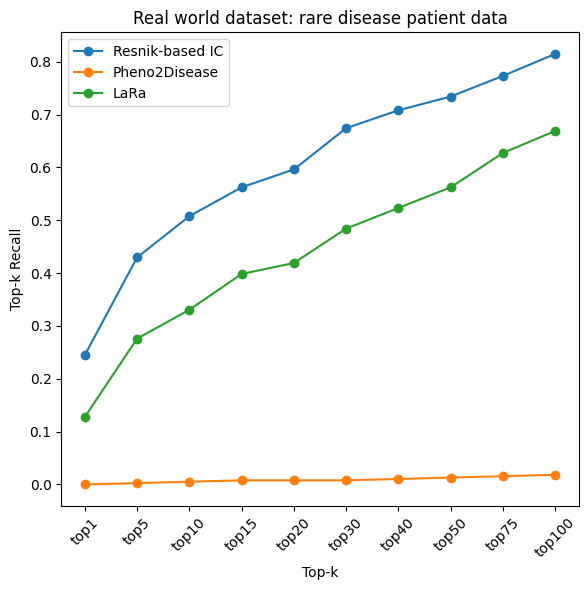

In [15]:
# Figure 3

import matplotlib.pyplot as plt
import pandas as pd

fig_df = pd.DataFrame([base_data, pd_data, model_data], index=['Resnik-based IC', 'Pheno2Disease', 'LaRa'])
fig_df.index.name = 'Method'


# Example DataFrame
# Plotting the recall curve
plt.figure(figsize=(6, 6))
for index, row in fig_df.iterrows():
    plt.plot(list(row.index), list(row.values), marker='o', label=index)

plt.title('Real world dataset: rare disease patient data')
plt.xlabel('Top-k')
plt.ylabel('Top-k Recall')
plt.xticks(rotation=45)
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()